In [1]:
import pandas as pd
import numpy as np
import nltk
import gensim
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer
from data import source_wsl, output	
from util import stat
from util import Pipeline, text

sia = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()

def token_to_sentiment(row):
    text_ = " ".join(row)
    return pd.Series(sia.polarity_scores(text_))

# input original text
text_preprocess = Pipeline.from_config({
	'replace emoji': [text.replace_emoji],
	'remove retweet symbol': [text.remove_retweet],
	'remove url': [(text.remove_pattern, text.PATTERN['url'])],
	'remove punctuation': [(text.remove_pattern, text.PATTERN['slight punc'])],  # ATTENTION: it will remove @ #
	'to lower': [str.lower],
	'remove _': [(text.replace_pattern, r'_', ' ')],
	'tokenize': [nltk.tokenize.word_tokenize],
	'lemmatize': [text.lemmatize],
	'remove stopwords': [(text.remove_stopwords, text.STOP_WORDS + ['amp'])],
})[0]

In [2]:
data = pd.read_csv(source_wsl)  # class: 0=hate, 1=offensive, 2=normal
data

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [3]:
data['class'].value_counts()  # 0: hate, 1: offensive, 2: neither

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

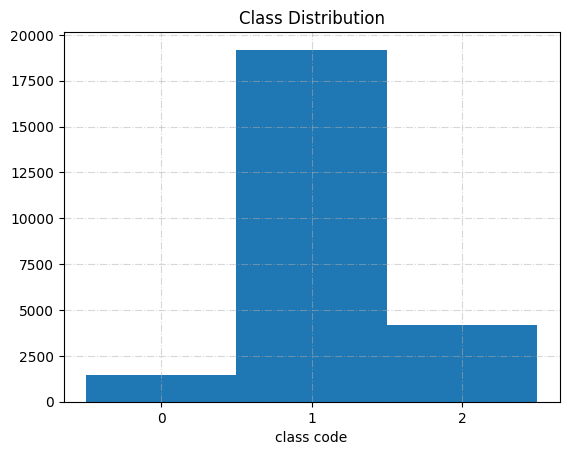

In [4]:
title = "Class Distribution"
plt.title(title)
plt.xlabel("class code")
plt.grid(alpha=0.5,linestyle='-.')
plt.xticks([0, 1, 2])
plt.bar(x = [1, 2, 0], height=data['class'].value_counts(), width=1)
plt.savefig(output + f'/img/{title}.svg')

In [5]:
data['num_at'] = data['tweet'].apply(stat.count_at)
data['num_url'] = data['tweet'].apply(stat.count_url)
data['num_hashtag'] = data['tweet'].apply(stat.count_hashtag)
data['num_retweet'] = data['tweet'].apply(stat.count_retweet)

data['num_exclamation'] = data['tweet'].apply(stat.count_pattern, args=('!',))
data['num_uppercase_word'] = data['tweet'].apply(stat.count_uppercase_word)
data['num_lowercase_word'] = data['tweet'].apply(stat.count_lowercase_word)

data['num_emoji'] = data['tweet'].apply(stat.count_pattern, args=(text.PATTERN['emoji'],))
data

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,num_at,num_url,num_hashtag,num_retweet,num_exclamation,num_uppercase_word,num_lowercase_word,num_emoji
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,1,0,0,1,3,1,23,0
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,0,0,1,7,1,13,0
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,2,0,0,2,11,2,13,0
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,2,0,0,1,9,1,5,0
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,0,1,1,13,1,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,3,0,3,0,1,1,13,3
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",0,0,0,0,0,0,14,0
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,0,0,0,0,2,1,12,0
24781,6,0,6,0,1,youu got wild bitches tellin you lies,0,0,0,0,0,0,7,0


In [6]:
def process(tweets: pd.Series, pipeline):
	return pd.Series([pipeline(tweet) for tweet in tweets.to_numpy()])

clean_text = process(data['tweet'], text_preprocess)
clean_text

0        [!, !, !, mayasolovely, woman, n't, complain, ...
1        [!, !, !, !, !, mleew17, boy, coldtyga, dwn, c...
2        [!, !, !, !, !, !, !, urkindofbrand, dawg, !, ...
3        [!, !, !, !, !, !, !, !, !, g, anderson, viva,...
4        [!, !, !, !, !, !, !, !, !, !, !, !, !, shenik...
                               ...                        
24778    ['s, muthafin, lie, lifeasking, 20, pearl, cor...
24779    ['ve, broke, wrong, heart, baby, drove, rednec...
24780    [young, buck, wan, eat, !, !, nigguh, fuckin, ...
24781                     [youu, wild, bitch, tellin, lie]
24782    [ruffled, ntac, eileen, dahlia, beautiful, col...
Length: 24783, dtype: object

In [7]:
data = pd.concat([data, clean_text._set_name('clean text')], axis=1)
data

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,num_at,num_url,num_hashtag,num_retweet,num_exclamation,num_uppercase_word,num_lowercase_word,num_emoji,clean text
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,1,0,0,1,3,1,23,0,"[!, !, !, mayasolovely, woman, n't, complain, ..."
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,0,0,1,7,1,13,0,"[!, !, !, !, !, mleew17, boy, coldtyga, dwn, c..."
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,2,0,0,2,11,2,13,0,"[!, !, !, !, !, !, !, urkindofbrand, dawg, !, ..."
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,2,0,0,1,9,1,5,0,"[!, !, !, !, !, !, !, !, !, g, anderson, viva,..."
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,0,1,1,13,1,21,1,"[!, !, !, !, !, !, !, !, !, !, !, !, !, shenik..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,3,0,3,0,1,1,13,3,"['s, muthafin, lie, lifeasking, 20, pearl, cor..."
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",0,0,0,0,0,0,14,0,"['ve, broke, wrong, heart, baby, drove, rednec..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,0,0,0,0,2,1,12,0,"[young, buck, wan, eat, !, !, nigguh, fuckin, ..."
24781,6,0,6,0,1,youu got wild bitches tellin you lies,0,0,0,0,0,0,7,0,"[youu, wild, bitch, tellin, lie]"


In [8]:
sentiment = clean_text.apply(token_to_sentiment)
sentiment

,neg,neu,pos,compound
0,0.000,0.668,0.332,0.4563
1,0.000,1.000,0.000,0.0000
2,0.814,0.186,0.000,-0.9550
3,0.000,1.000,0.000,0.0000
4,0.682,0.318,0.000,-0.8614
...,...,...,...,...
24778,0.000,1.000,0.000,0.0000
24779,0.624,0.376,0.000,-0.8074
24780,0.000,1.000,0.000,0.0000
24781,0.487,0.513,0.000,-0.5859


In [9]:
data_senti = pd.concat([data, sentiment], axis=1)
data_senti

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,num_at,num_url,num_hashtag,num_retweet,num_exclamation,num_uppercase_word,num_lowercase_word,num_emoji,clean text,neg,neu,pos,compound
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,1,0,0,1,3,1,23,0,"[!, !, !, mayasolovely, woman, n't, complain, ...",0.000,0.668,0.332,0.4563
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,0,0,1,7,1,13,0,"[!, !, !, !, !, mleew17, boy, coldtyga, dwn, c...",0.000,1.000,0.000,0.0000
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,2,0,0,2,11,2,13,0,"[!, !, !, !, !, !, !, urkindofbrand, dawg, !, ...",0.814,0.186,0.000,-0.9550
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,2,0,0,1,9,1,5,0,"[!, !, !, !, !, !, !, !, !, g, anderson, viva,...",0.000,1.000,0.000,0.0000
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,0,1,1,13,1,21,1,"[!, !, !, !, !, !, !, !, !, !, !, !, !, shenik...",0.682,0.318,0.000,-0.8614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,3,0,3,0,1,1,13,3,"['s, muthafin, lie, lifeasking, 20, pearl, cor...",0.000,1.000,0.000,0.0000
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",0,0,0,0,0,0,14,0,"['ve, broke, wrong, heart, baby, drove, rednec...",0.624,0.376,0.000,-0.8074
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,0,0,0,0,2,1,12,0,"[young, buck, wan, eat, !, !, nigguh, fuckin, ...",0.000,1.000,0.000,0.0000
24781,6,0,6,0,1,youu got wild bitches tellin you lies,0,0,0,0,0,0,7,0,"[youu, wild, bitch, tellin, lie]",0.487,0.513,0.000,-0.5859


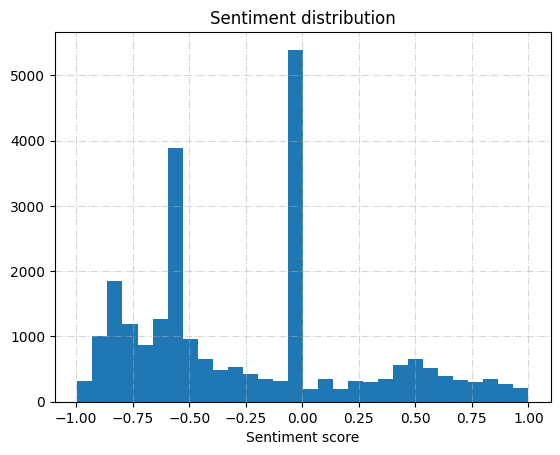

In [10]:
title = "Sentiment distribution"
plt.title(title)
plt.xlabel("Sentiment score")
plt.grid(alpha=0.5,linestyle='-.')
plt.hist(data_senti['compound'], bins=30)
plt.savefig(output + f'/img/{title}.svg')

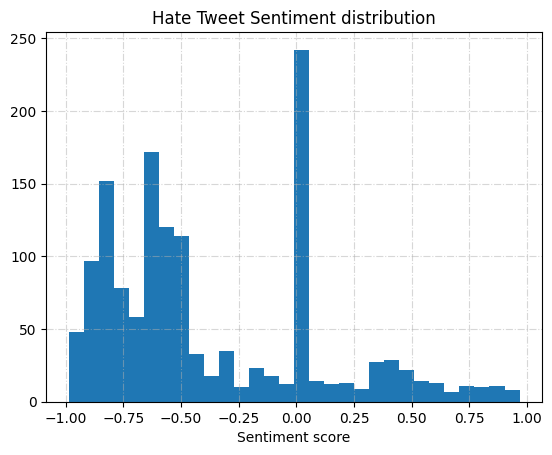

In [11]:
title = "Hate Tweet Sentiment distribution"
plt.title(title)
plt.xlabel("Sentiment score")
plt.grid(alpha=0.5,linestyle='-.')
plt.hist(data_senti[data_senti['class'] == 0]['compound'], bins=30)
plt.savefig(output + f'/img/{title}.svg')

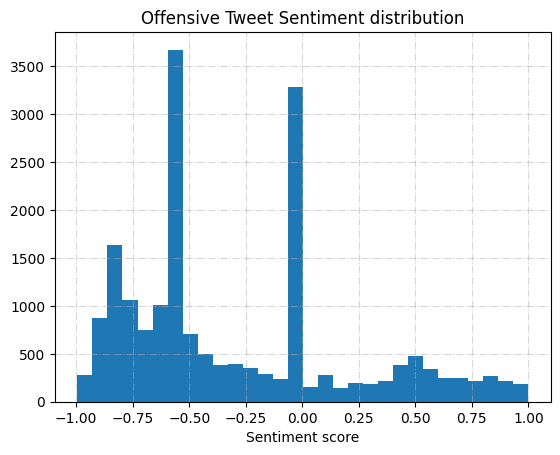

In [12]:
title = "Offensive Tweet Sentiment distribution"
plt.title(title)
plt.xlabel("Sentiment score")
plt.grid(alpha=0.5,linestyle='-.')
plt.hist(data_senti[data_senti['class'] == 1]['compound'], bins=30)
plt.savefig(output + f'/img/{title}.svg')

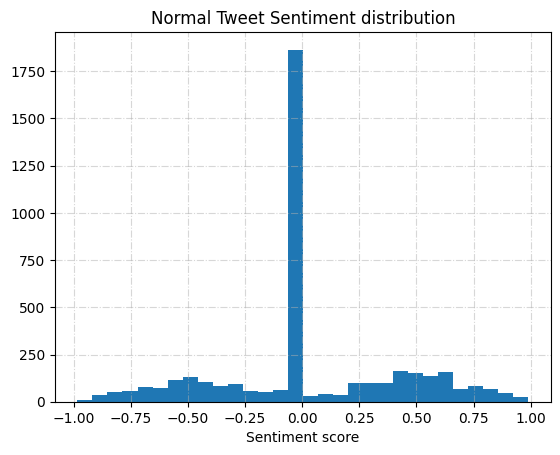

In [13]:
title = "Normal Tweet Sentiment distribution"
plt.title(title)
plt.xlabel("Sentiment score")
plt.grid(alpha=0.5,linestyle='-.')
plt.hist(data_senti[data_senti['class'] == 2]['compound'], bins=30)
plt.savefig(output + f'/img/{title}.svg')

In [14]:
vectorizer = TfidfVectorizer()
selector = SelectKBest(k=5)

vectors = vectorizer.fit_transform(clean_text.apply(lambda row: " ".join(row)))
features = selector.fit_transform(vectors,y=data['class'])
features

<24783x5 sparse matrix of type '<class 'numpy.float64'>'
	with 13166 stored elements in Compressed Sparse Row format>

In [15]:
silhouette_score(features, data['class'])

0.17538651731640095

In [16]:
features.toarray()

array([[0.        , 0.        , 0.        , 0.2230963 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.09841977, 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.11174954, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [17]:
new_features = np.concatenate([features.toarray(), data.loc[:, ['num_at', 'num_url', 'num_exclamation', 'num_uppercase_word']].to_numpy()], axis=1)
new_features

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         3.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         7.        ,  1.        ],
       [ 0.        ,  0.09841977,  0.        , ...,  0.        ,
        11.        ,  2.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         2.        ,  1.        ],
       [ 0.        ,  0.11174954,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ]])

In [18]:
silhouette_score(new_features, data['class'])

0.010397587052216247

In [19]:
data

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,num_at,num_url,num_hashtag,num_retweet,num_exclamation,num_uppercase_word,num_lowercase_word,num_emoji,clean text
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,1,0,0,1,3,1,23,0,"[!, !, !, mayasolovely, woman, n't, complain, ..."
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,0,0,1,7,1,13,0,"[!, !, !, !, !, mleew17, boy, coldtyga, dwn, c..."
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,2,0,0,2,11,2,13,0,"[!, !, !, !, !, !, !, urkindofbrand, dawg, !, ..."
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,2,0,0,1,9,1,5,0,"[!, !, !, !, !, !, !, !, !, g, anderson, viva,..."
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,0,1,1,13,1,21,1,"[!, !, !, !, !, !, !, !, !, !, !, !, !, shenik..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,3,0,3,0,1,1,13,3,"['s, muthafin, lie, lifeasking, 20, pearl, cor..."
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",0,0,0,0,0,0,14,0,"['ve, broke, wrong, heart, baby, drove, rednec..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,0,0,0,0,2,1,12,0,"[young, buck, wan, eat, !, !, nigguh, fuckin, ..."
24781,6,0,6,0,1,youu got wild bitches tellin you lies,0,0,0,0,0,0,7,0,"[youu, wild, bitch, tellin, lie]"


In [20]:
_1 = data[data['class'] == 0]
__1 = (_1['num_at'] + _1['num_url'] + _1['num_hashtag'] + _1['num_retweet']).value_counts()
__1 /= sum(__1)
__1

1     0.312587
0     0.255245
2     0.184615
3     0.111888
4     0.062937
5     0.031469
6     0.016084
7     0.009790
8     0.005594
9     0.003497
11    0.002098
10    0.002098
14    0.000699
20    0.000699
12    0.000699
Name: count, dtype: float64

In [21]:
_2 = data[data['class'] == 1]
__2 = (_2['num_at'] + _2['num_url'] + _2['num_hashtag'] + _2['num_retweet']).value_counts()
__2 /= sum(__2)
__2

0     0.324857
1     0.199218
2     0.189161
3     0.125065
4     0.053465
5     0.037572
6     0.023398
7     0.014591
8     0.010422
9     0.007243
10    0.003596
11    0.003231
12    0.002189
13    0.001563
15    0.000886
14    0.000782
16    0.000417
18    0.000365
17    0.000313
24    0.000156
25    0.000156
26    0.000156
23    0.000156
19    0.000156
49    0.000104
39    0.000104
27    0.000104
31    0.000104
20    0.000104
64    0.000052
65    0.000052
29    0.000052
22    0.000052
42    0.000052
79    0.000052
21    0.000052
Name: count, dtype: float64

In [22]:
_3 = data[data['class'] == 2]
__3 = (_3['num_at'] + _3['num_url'] + _3['num_hashtag'] + _3['num_retweet']).value_counts()
__3 /= sum(__3)
__3

1     0.238770
0     0.218352
2     0.177997
3     0.171031
4     0.073505
5     0.045640
6     0.033389
7     0.013212
8     0.010810
9     0.004564
10    0.004084
14    0.002162
11    0.001922
12    0.001681
13    0.000961
15    0.000721
16    0.000721
17    0.000240
69    0.000240
Name: count, dtype: float64

In [23]:
__ = pd.concat([__1, __2, __3],axis=1).fillna(0)
__

,count,count,count
1,0.312587,0.199218,0.238770
0,0.255245,0.324857,0.218352
2,0.184615,0.189161,0.177997
3,0.111888,0.125065,0.171031
4,0.062937,0.053465,0.073505
5,0.031469,0.037572,0.045640
6,0.016084,0.023398,0.033389
7,0.009790,0.014591,0.013212
8,0.005594,0.010422,0.010810
9,0.003497,0.007243,0.004564


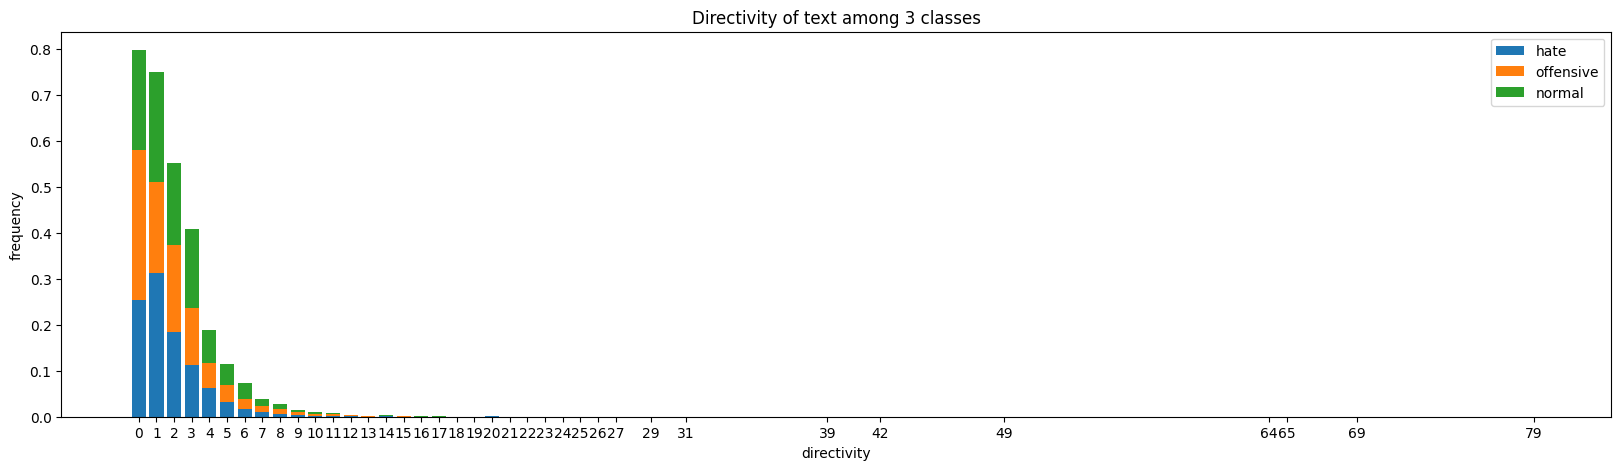

In [24]:
title = "Directivity of text among 3 classes"
plt.figure(figsize=(20, 5))
plt.title(title)
plt.xticks(__.index)
plt.xlabel("directivity")
plt.ylabel("frequency")
plt.bar(x=__.index, height=__.iloc[:, 0], label='hate')
plt.bar(x=__.index, height=__.iloc[:, 1], bottom=__.iloc[:, 0], label='offensive')
plt.bar(x=__.index, height=__.iloc[:, 2], bottom=__.iloc[:, 0] + __.iloc[:, 1], label='normal')
plt.legend()
plt.savefig(output + f'/img/{title}.png')
# class: 0=hate, 1=offensive, 2=normal

In [25]:
_1 = data[data['class'] == 0]
__1 = (_1['num_uppercase_word'] + _1['num_exclamation']).value_counts()
__1 /= sum(__1)
__1

0     0.511888
1     0.283916
2     0.106294
3     0.058042
4     0.019580
7     0.005594
5     0.004196
6     0.004196
8     0.003497
11    0.000699
13    0.000699
38    0.000699
10    0.000699
Name: count, dtype: float64

In [26]:
_2 = data[data['class'] == 1]
__2 = (_2['num_uppercase_word'] + _2['num_exclamation']).value_counts()
__2 /= sum(__2)
__2

0     0.412402
1     0.341167
2     0.143669
3     0.053674
4     0.022095
5     0.011412
6     0.006305
7     0.003804
8     0.001459
9     0.001251
10    0.000886
12    0.000469
13    0.000417
11    0.000365
14    0.000261
19    0.000104
25    0.000052
27    0.000052
16    0.000052
18    0.000052
26    0.000052
Name: count, dtype: float64

In [27]:
_3 = data[data['class'] == 2]
__3 = (_3['num_uppercase_word'] + _3['num_exclamation']).value_counts()
__3 /= sum(__3)
__3

0     0.381936
1     0.345664
2     0.147009
3     0.062215
4     0.027144
5     0.011770
8     0.006726
7     0.006486
6     0.004804
9     0.001681
10    0.001201
15    0.000721
17    0.000480
14    0.000480
12    0.000480
19    0.000240
13    0.000240
22    0.000240
30    0.000240
11    0.000240
Name: count, dtype: float64

In [28]:
__ = pd.concat([__1, __2, __3],axis=1).fillna(0)
__

,count,count,count
0,0.511888,0.412402,0.381936
1,0.283916,0.341167,0.345664
2,0.106294,0.143669,0.147009
3,0.058042,0.053674,0.062215
4,0.019580,0.022095,0.027144
7,0.005594,0.003804,0.006486
5,0.004196,0.011412,0.011770
6,0.004196,0.006305,0.004804
8,0.003497,0.001459,0.006726
11,0.000699,0.000365,0.000240


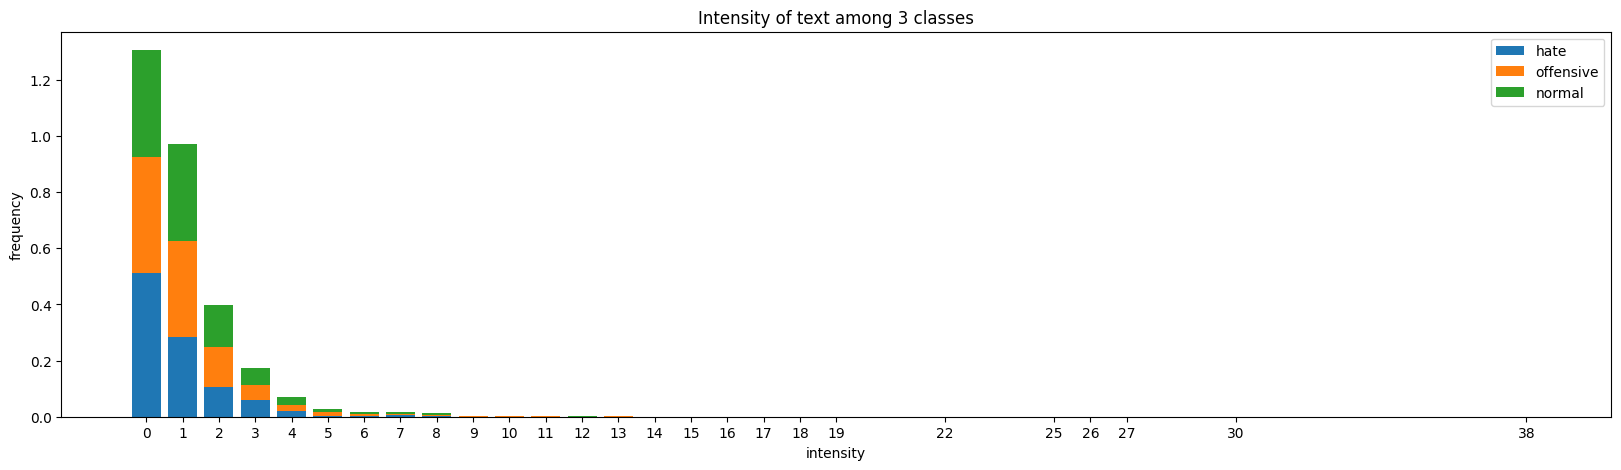

In [29]:
title = "Intensity of text among 3 classes"
plt.figure(figsize=(20, 5))
plt.title(title)
plt.xticks(__.index)
plt.xlabel("intensity")
plt.ylabel("frequency")
plt.bar(x=__.index, height=__.iloc[:, 0], label='hate')
plt.bar(x=__.index, height=__.iloc[:, 1], bottom=__.iloc[:, 0], label='offensive')
plt.bar(x=__.index, height=__.iloc[:, 2], bottom=__.iloc[:, 0] + __.iloc[:, 1], label='normal')
plt.legend()
plt.savefig(output + f'/img/{title}.png')

In [30]:
__1 = _1['num_emoji'].value_counts()
__1 /= sum(__1)
__1

num_emoji
0     0.852448
1     0.059441
2     0.048951
3     0.020979
4     0.005594
5     0.005594
6     0.002797
7     0.002098
11    0.000699
8     0.000699
17    0.000699
Name: count, dtype: float64

In [31]:
__2 = _2['num_emoji'].value_counts()
__2 /= sum(__2)
__2

num_emoji
0     0.748828
1     0.093695
2     0.068734
3     0.034393
4     0.019854
5     0.010474
6     0.007608
7     0.004221
8     0.003856
9     0.002345
10    0.001407
11    0.000938
12    0.000782
13    0.000573
14    0.000469
15    0.000208
23    0.000208
24    0.000156
18    0.000156
25    0.000104
47    0.000104
27    0.000104
17    0.000104
16    0.000104
39    0.000052
65    0.000052
19    0.000052
63    0.000052
21    0.000052
40    0.000052
77    0.000052
20    0.000052
22    0.000052
36    0.000052
28    0.000052
Name: count, dtype: float64

In [32]:
__3 = _3['num_emoji'].value_counts()
__3 /= sum(__3)
__3

num_emoji
0     0.766034
1     0.133077
2     0.058612
3     0.016815
4     0.009128
5     0.004804
6     0.004804
13    0.002162
7     0.001201
12    0.000721
8     0.000721
9     0.000480
10    0.000480
14    0.000240
15    0.000240
66    0.000240
11    0.000240
Name: count, dtype: float64

In [33]:
__ = pd.concat([__1, __2, __3],axis=1).fillna(0)
__

,count,count,count
num_emoji,,,
0,0.852448,0.748828,0.766034
1,0.059441,0.093695,0.133077
2,0.048951,0.068734,0.058612
3,0.020979,0.034393,0.016815
4,0.005594,0.019854,0.009128
5,0.005594,0.010474,0.004804
6,0.002797,0.007608,0.004804
7,0.002098,0.004221,0.001201
11,0.000699,0.000938,0.000240


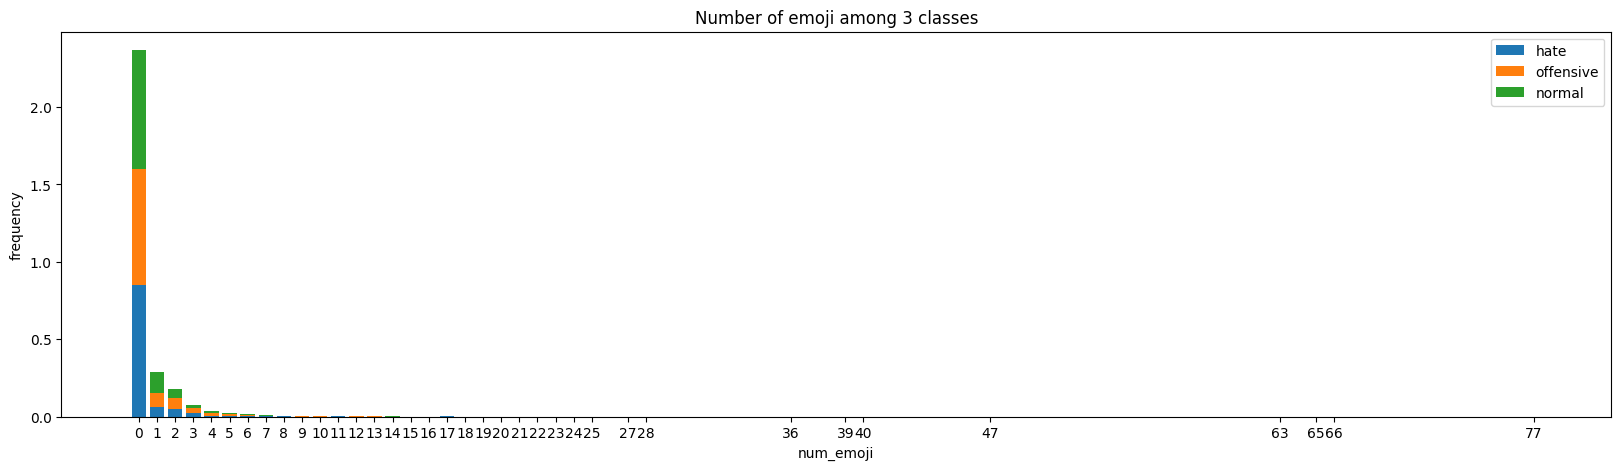

In [34]:
title = "Number of emoji among 3 classes"
plt.figure(figsize=(20, 5))
plt.title(title)
plt.xticks(__.index)
plt.xlabel("num_emoji")
plt.ylabel("frequency")
plt.bar(x=__.index, height=__.iloc[:, 0], label='hate')
plt.bar(x=__.index, height=__.iloc[:, 1], bottom=__.iloc[:, 0], label='offensive')
plt.bar(x=__.index, height=__.iloc[:, 2], bottom=__.iloc[:, 0] + __.iloc[:, 1], label='normal')
plt.legend()
plt.savefig(output + f'/img/{title}.png')

# Word Count -- Word Cloud

In [35]:
def flatten(tokens_list: list[list[str]]):
	output = []
	for tokens in tokens_list:
		output += [lemmatizer.lemmatize(token) for token in tokens]
	return output

hate_tokens = flatten(data[data['class'] == 0]['clean text'].to_list())
offensive_tokens = flatten(data[data['class'] == 1]['clean text'].to_list())
normal_tokens = flatten(data[data['class'] == 2]['clean text'].to_list())

In [36]:
pd.Series(hate_tokens).value_counts()

bitch              266
!                  253
faggot             248
nigga              216
?                  175
                  ... 
feather              1
fisted               1
erinscafe            1
femalejokerhoee      1
rush                 1
Name: count, Length: 4289, dtype: int64

In [37]:
pd.Series(offensive_tokens).value_counts()

bitch        11063
!             3276
n't           3167
tear          2987
joy           2984
             ...  
ménage           1
palace           1
bepatient        1
coney            1
hymn             1
Name: count, Length: 23886, dtype: int64

In [38]:
pd.Series(normal_tokens).value_counts()

!             840
trash         692
's            570
?             515
bird          462
             ... 
infiltrate      1
handbook        1
kidnap          1
5200            1
coll            1
Name: count, Length: 11764, dtype: int64

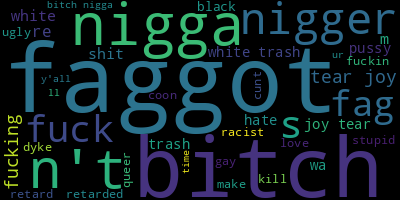

In [39]:
wordcloud1 = WordCloud(max_words=40)
wordcloud1.generate(" ".join(hate_tokens))
wordcloud1.to_file(output + '/img/hate words.png')
wordcloud1.to_image()

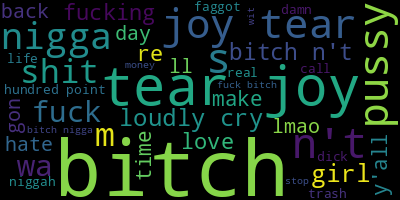

In [40]:
wordcloud2 = WordCloud(max_words=40)
wordcloud2.generate(" ".join(offensive_tokens))
wordcloud2.to_file(output + '/img/offensive words.png')
wordcloud2.to_image()

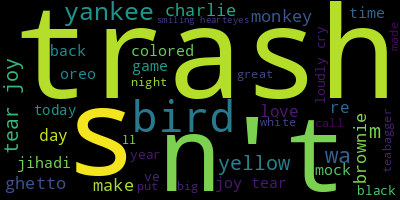

In [41]:
wordcloud3 = WordCloud(max_words=40)
wordcloud3.generate(" ".join(normal_tokens))
wordcloud3.to_file(output + '/img/normal words.png')
wordcloud3.to_image()

# Topic

In [42]:
def get_topics(tokens: list[str], num_topic: int = 20, num_word: int = 10):
	dictionary = gensim.corpora.Dictionary(tokens)
	corpus = [dictionary.doc2bow(document) for document in tokens]
	lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, passes=num_word)
	return lda_model.print_topics(num_topic, num_word)

In [43]:
get_topics(data[data['class'] == 0]['clean text'], 5, 6)

[(0,
  '0.047*"!" + 0.023*"fag" + 0.017*"n\'t" + 0.012*"\'s" + 0.010*"trash" + 0.006*"white"'),
 (1,
  '0.025*"?" + 0.023*"white" + 0.021*"!" + 0.016*"faggot" + 0.015*"trash" + 0.012*"\'s"'),
 (2,
  '0.036*"nigga" + 0.020*"n\'t" + 0.012*"nigger" + 0.009*"bitch" + 0.008*"fucking" + 0.007*"\'s"'),
 (3,
  '0.026*"tear" + 0.025*"joy" + 0.025*"bitch" + 0.020*"nigga" + 0.017*"nigger" + 0.015*"!"'),
 (4,
  '0.036*"faggot" + 0.036*"bitch" + 0.014*"?" + 0.012*"\'s" + 0.009*"n\'t" + 0.009*"nigger"')]

In [44]:
get_topics(data[data['class'] == 1]['clean text'], 5, 6)

[(0,
  '0.097*"!" + 0.080*"tear" + 0.080*"joy" + 0.044*"bitch" + 0.027*"hand" + 0.018*"cry"'),
 (1,
  '0.080*"bitch" + 0.026*"n\'t" + 0.017*"\'s" + 0.016*"?" + 0.014*"\'m" + 0.012*"shit"'),
 (2,
  '0.049*"bitch" + 0.017*"\'s" + 0.015*"smiling" + 0.012*"woman" + 0.012*"nigga" + 0.011*"point"'),
 (3,
  '0.119*"bitch" + 0.036*"n\'t" + 0.026*"nigga" + 0.017*"fuck" + 0.012*"shit" + 0.011*"?"'),
 (4,
  '0.085*"pussy" + 0.030*"bitch" + 0.020*"?" + 0.013*"n\'t" + 0.008*"love" + 0.007*"eat"')]

In [45]:
get_topics(data[data['class'] == 2]['clean text'], 5, 6)

[(0,
  '0.014*"trash" + 0.013*"brownie" + 0.012*"\'s" + 0.010*"yankee" + 0.010*"n\'t" + 0.009*"oreo"'),
 (1,
  '0.013*"?" + 0.013*"\'s" + 0.012*"charlie" + 0.009*"trash" + 0.009*"bird" + 0.007*"n\'t"'),
 (2,
  '0.031*"\'s" + 0.023*"trash" + 0.014*"bird" + 0.008*"n\'t" + 0.007*"yankee" + 0.007*"kid"'),
 (3,
  '0.072*"!" + 0.027*"bird" + 0.014*"?" + 0.011*"monkey" + 0.008*"n\'t" + 0.007*"yellow"'),
 (4,
  '0.054*"trash" + 0.013*"tear" + 0.013*"joy" + 0.011*"\'s" + 0.009*"yellow" + 0.008*"friend"')]